Grouplevel test of accuracy and F1-score of 8 algorithms.

In [27]:
# Compare Algorithms to determine which algorithms should be tuned
import cx_Oracle
import pandas as pd
import numpy as np
import time
    
import pandas
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

con = cx_Oracle.connect('hanzefitbit/hanzefitbit@127.0.0.1/xe')

# load dataset
#select data from measurements
#added case to select only the weeks where coaching took place research group 1 started in week 5 with coaching, research group 2 started in week 16 with coaching
cur = con.cursor()
cur.execute('select id,treatment_id,year,week,weekday,hour,sum_steps, sum_steps_hour,daily_steps from hft_sum_steps_v where \
             hour in (7,8,9,10,11,12,13,14,15,16,17,18) \
             and weekday not in (5,6) and year=2015 and (case when research_group=2 and week>15 then 1 when research_group=1 and week>4 then 1 else 0 end = 1)\
             order by year,week,weekday,hour')     
df_dataframe= pd.DataFrame(cur.fetchall(),columns=['id','treatment_id','year','week','weekday','hour','sum_steps','sum_steps_hour','daily_steps'])
#cur.close()

#select avg steps per day 
cur = con.cursor()
cur.execute( 'select avg(sum_steps_hour) avg_daily_steps from hft_sum_steps_v where\
              year=2015 and hour=18 and weekday not in (5,6) and (case when research_group=2 and week>15 then 1 when research_group=1 and week>4 then 1 else 0 end = 1)\
              ')
df_threshold= pd.DataFrame(cur.fetchall(),columns=['avg_daily_steps'])
cur.close()

#function to determine if people have reached their goal of the day

def daily_steps_cat_f (steps_value,threshold):
    if (steps_value<threshold):
        #print('smaller then threshold')
        return 0
    if (steps_value>=threshold):
        #print('more then threshold')
        return 1

#determine category.

x=df_dataframe['daily_steps']
y=df_threshold['avg_daily_steps']
df_dataframe['dailysteps_cat']=np.vectorize(daily_steps_cat_f)(x, y)

#make datasets
X= df_dataframe.iloc[:, 5:8].values
y=df_dataframe.iloc[:, 9].values
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(np_scaled)

X_train_s,X_test_s,y_train,y_test=train_test_split(X_scaled,y, test_size=0.3, random_state=10)    
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=10)    

# prepare models
models = []
models.append(('ADA',AdaBoostClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('NN',MLPClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('SGD',linear_model.SGDClassifier()))
models.append(('SVC',SVC()))






results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=7)
    if name in ('SVC','SGD','KNN','NN'):
        cv_results = model_selection.cross_val_score(model, X_train_s, y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ADA: 0.854157 (0.001626)
DT: 0.804220 (0.003006)
KNN: 0.829826 (0.005544)
LR: 0.825725 (0.008487)
NN: 0.852797 (0.002938)
RF: 0.819065 (0.003840)
SGD: 0.853575 (0.004574)
SVC: 0.856341 (0.002405)


C:\Users\talko\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [26]:
# boxplot algorithm comparison
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=7)
    if name in ('SVC','SGD','KNN','NN'):
        cv_results = model_selection.cross_val_score(model, X_train_s, y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    


ADA: 0.776623 (0.002080)
DT: 0.720535 (0.004787)
KNN: 0.749171 (0.005683)
LR: 0.742125 (0.009821)
NN: 0.777774 (0.001545)
RF: 0.737451 (0.003210)
SGD: 0.767623 (0.005490)
SVC: 0.770728 (0.002505)


C:\Users\talko\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


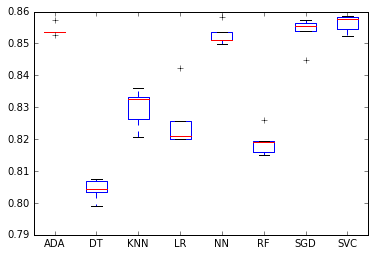

In [28]:
# boxplot algorithm comparison
fig = plt.figure()
#fig.suptitle('Algorithm F1-score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()